<a href="https://colab.research.google.com/github/amunwes/Elec-400M/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import GridSearchCV, KFold
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score

from timeit import default_timer as timer



import and clean the data

In [ ]:
#@title LUT
# genre lookup table sets

main_genre_LUT = {
    'action':{'doomsday', 'disaster', 'superhero', 'revenge'},
    'adult' : {'softcore porn', 'softcore pornography', 'hardcore pornography', 'erotica', 'erotic', 'sexploitation', 'pornography', 'pornographic','homoeroticism', 'sex', 'pinku eiga', 'porn'},
    'adventure':{'jungle', 'epic', 'swashbucklers', 'travel', 'road'},
    'animation':{'anime', 'silhouette animation', 'supermarionation','clay', 'cartoon', 'stop motion', 'computer animation', 'animated'},
    'b-movie':{},
    'black-and-white':{'goat gland', 'silent'},
    'comedy':{'stand-up', 'beach party', 'beach', 'comedy of manners', 'comedy of errors', 'satire', 'buddy', 'humour', 'comedies', 'stoner', 'slapstick', 'screwball', 'parody'},
    'crime':{'addiction', 'juvenile delinquency', 'criminals', 'law & crime', 'women in prisons', 'biker', 'legal', 'detective', 'cop', 'prison', 'outlaw', 'heist', 'courtroom', 'gangster', 'caper', 'escape'},
    'documentary':{'documentaries', 'documetary', 'hagiography', 'nature', 'mockumentary', 'mondo', 'biography', 'biographical', 'biopic [feature]', 'film à clef', 'film & television history'},
    'drama':{'slice of life', 'slice of life story', 'interpersonal relationships', 'melodrama', 'tragedy', 'coming-of-age','coming of age', 'medical'},
    'educational':{'archaeology', 'essay', 'language & literature', 'media studies', 'news', 'environmental science', 'archives and records', 'libraries and librarians', 'graphic & applied arts', 'computers', 'inventions & innovations', 'finance & investing', 'business', 'anthropology', 'linguistics', 'education'},
    'family':{'children\'s issues', 'childhood', 'family & personal relationships', 'children\'s', 'teen', 'holiday', 'school story', 'family-oriented'},
    'fantasy':{'fantasies', 'sword and sorcery', 'sword and sorcerys', 'fairy tale', 'revisionist fairy tale'},
    'fiction':{'dystopia', 'fictional'},
    'historical':{'mythological', 'period piece','history','period', 'sword and sandal' },
    'holiday':{'christmas'},
    'horror':{ 'road-horror', 'psycho-biddy', 'demonic child', 'alien invasion', 'scary', 'slasher', 'monster','zombie', 'alien', 'creature', 'demonic', 'z', 'horrors'},
    'indie':{'avant-garde', 'dogme 95', 'expressionism', 'mumblecore', 'absurdism', 'experimental', 'surrealism', 'existentialism', 'gross out', 'gross-out', 'art', 'fan'},
    'lgbt':{'gender issues', 'gay', 'gay interest', 'gay themed', 'new queer'},
    'musical':{'singing', 'dance', 'punk rock', 'concert', 'opera', 'instrumental music', 'operetta', 'music', 'breakdance', 'hip hops', 'hip hop', 'film-opera', 'singing '},
    'mystery':{'whodunit', 'conspiracy'},
    'political':{'black', 'social problem', 'americana', 'blaxploitation', 'media', 'albino bias', 'exploitation', 'early black', 'race', 'patriotic', 'feminist', 'social issues', 'neorealism', 'journalism', 'anti-war', 'culture & society', 'propaganda'},
    'religious':{'heavenly', 'christian'},
    'romance':{'chick flick', 'romantic'},
    'sci-fi':{'time travel', 'steampunk', 'sci fis originals', 'sci fi pictures originals', 'science', 'space', 'cyberpunk'},
    'short':{'movie serial', 'anthology', 'television'},
    'sports':{'racing', 'auto racing', 'horse racing', 'parkour in popular culture', 'bruceploitation', 'health & fitness', 'baseball', 'boxing', 'martial arts'},
    'spy':{'glamorized spy'},
    'supernatural':{'werewolf','haunted house', 'vampires'},
    'suspense':{'kafkaesque'},
    'thriller':{'thrillers','plague', 'psychological'},
    'war':{'combats', 'cavalry', 'foreign legion', 'warfare', 'private military company', 'the netherlands in world war ii'},
    'western':{'spaghetti western', 'cowboy', 'hybrid western', 'revisionist western'},
    'world':{'domestic', 'new hollywood', 'tamil', 'tollywood', 'british empire', 'indian', 'british new wave', 'malayalam', 'bengali', 'northern', 'czechoslovak new wave', 'latino', 'tokusatsu', 'bollywood', 'wuxia','japanese','japaneses', 'chinese', 'chineses','filipino', 'filipinos', 'ninja', 'samurai', 'foreign'},
     }
# main_genre_LUT
  # genres = genres.apply(lambda y: list(map(lambda x: x.replace("crime drama", "drama"), y)) )

In [ ]:
# function to search through a series of strings containing movie genres and convert unique genres to their more common counter parts
def split_genre(l, sep=' '):

  l2 = (item.split(sep) if sep in item else [item] for item in l)
  l3 = [x for val in l2 for x in val]
  l4 = set(l3)
  return l4

def filter_sub_genre(l, main_genre, sub_genre):

  l2 = ([main_genre] if item in sub_genre else [item] for item in l)
  l3 = [x for val in l2 for x in val]
  l4 = set(l3)
  return l4

def remove_genre(l, target):

  l2 = ([None] if item == target else [item] for item in l)
  l3 = [x for val in l2 for x in val]
  l4 = [i for i in l3 if i is not None]
  l5 = set(l4)
  return l5

def clean_genres(series):
  # spelling corrections and special genres splits
  genres = series.apply(lambda y: list(map(lambda x: x.replace("comdedy", "comedy"), y)) )

  genres = genres.apply(lambda y: list(map(lambda x: x.replace("japaneses", "japanese"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("docudrama", "drama documentary"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("film noir", "crime drama"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("chase", "action adventure"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("gladiators", "action historical"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("illnesses & disabilities", "educational documentary"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("b-western", "b-movie western"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("giallo", "crime mystery"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("splatter", "horror crime"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("apocalyptic and post-apocalyptic", "sci-fi"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("rockumentary", "musical documentary"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("tragicomedy", "tragedy comedy"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("future noir", "science crime drama"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("neo-noir", "crime drama"), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("comedy-drama", "comedy drama"), y)) )
  # prefix and suffix removals
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" movie", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" film", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" cinema", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" effort", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" picture", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("nuclear ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("gulf ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("therimin ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("movies about ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("acid ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("cold ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" entertainment", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("film & television ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("ealing ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("heaven-can-wait ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("natural ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("backstage ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("master ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("inspirational ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("costume ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace(" story", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("workplace ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("marriage ", ""), y)) )
  genres = genres.apply(lambda y: list(map(lambda x: x.replace("jukebox ", ""), y)) )


  # unique removals
  genres = genres.apply(remove_genre, args=("star vehicle",))
  genres = genres.apply(remove_genre, args=("c-movie",))
  genres = genres.apply(remove_genre, args=("statutory rape",))
  genres = genres.apply(remove_genre, args=("live action",))
  genres = genres.apply(remove_genre, args=("film adaptation",))
  genres = genres.apply(remove_genre, args=("point of view shot",))
  genres = genres.apply(remove_genre, args=("camp",))
  genres = genres.apply(remove_genre, args=("bloopers & candid camera",))
  genres = genres.apply(remove_genre, args=("sponsored",))
  genres = genres.apply(remove_genre, args=("roadshow/carny",))
  genres = genres.apply(remove_genre, args=("reboot",))
  genres = genres.apply(remove_genre, args=("feature",))
  genres = genres.apply(remove_genre, args=("kitchen sink realism",))
  genres = genres.apply(remove_genre, args=("roadshow theatrical release",))
  genres = genres.apply(remove_genre, args=("airplanes and airports",))
  genres = genres.apply(remove_genre, args=("gothic",))
  genres = genres.apply(remove_genre, args=("remake",))
  genres = genres.apply(remove_genre, args=("pre-code",))
  genres = genres.apply(remove_genre, args=("animal",))
  genres = genres.apply(remove_genre, args=("ensemble",))
  genres = genres.apply(remove_genre, args=("filmed play",))

  for key in main_genre_LUT:
    genres = genres.apply(filter_sub_genre, args=(key, main_genre_LUT[key]))

  genres = genres.apply(split_genre, sep=' ')
  genres = genres.apply(split_genre, sep='/')
  for key in main_genre_LUT:
    genres = genres.apply(filter_sub_genre, args=(key, main_genre_LUT[key] ))

  # further cleanup of straggler genres that shouldnt exist
  genres = genres.apply(remove_genre, args=("film",))
  genres = genres.apply(remove_genre, args=("animals",))
  genres = genres.apply(remove_genre, args=("extreme",))
  genres = genres.apply(remove_genre, args=("female",))
  genres = genres.apply(remove_genre, args=("school",))
  genres = genres.apply(remove_genre, args=("world",))
  genres = genres.apply(remove_genre, args=("b-movie",))
  genres = genres.apply(remove_genre, args=("animation",))
  genres = genres.apply(remove_genre, args=("black-and-white",))


  return genres


In [ ]:
# grab datasets off gdrive
metadata_df = pd.read_table('/content/gdrive/MyDrive/data/imdb_movies_dataset/movie.metadata.tsv', header=None)

# rename the columns of our bigger datasets metadata to make it more legible
metadata_df.columns = ['movie_id','freebase_movie_id','movie_name','year','revenue','runtime(mins)','language','countries','genre']

id = []
synopsis = []

# read the summaries text and split it into 2 lists for movie id and synopsis
with open("/content/gdrive/MyDrive/data/imdb_movies_dataset/plot_summaries.txt", 'r') as f:
  lines = f.readlines()

for line in lines:
  id.append(line.split('\t')[0])
  synopsis.append(line.split('\t')[1])

# add the id and synopsis to our large dataset
dataset_42306 = pd.DataFrame({'movie_id': id, 'synopsis': synopsis})
# convert the id from int to string
metadata_df['movie_id'] = metadata_df['movie_id'].astype(str)
# merge the 2 dataframes based on movie_id
dataset_42306 = pd.merge(dataset_42306, metadata_df[['movie_id', 'movie_name', 'genre']], on = 'movie_id')
dataset_42306['genre'] = dataset_42306['genre'].str.lower()
# convert the values of our genre column from str to dict to list of values
dataset_42306['genre'] = dataset_42306['genre'].apply(lambda x: list(json.loads(x).values()))
# look at previous cells for custom made genre-cleaning algorithm
dataset_42306['genre'] = clean_genres(dataset_42306['genre'])
# remove entries that have no genre
dataset_41796 = dataset_42306[~(dataset_42306['genre'].str.len() == 0)]

# potentially reduce number of features here based on usage 363 genres is a bit steep
# all_genres = sum(dataset_41796['genre'],[])
# set(all_genres)
# dataset_41796['genre'].value_counts()


Text(0.5, 1.0, 'Occurences')

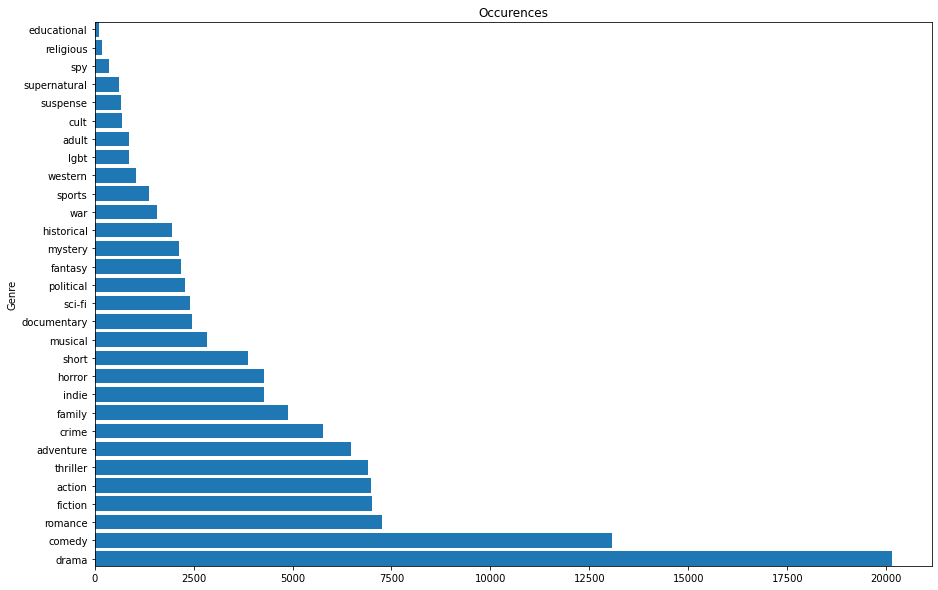

In [ ]:
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
# credit to Max Hilsdorf for this function
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

genres = to_1D(dataset_41796['genre'])

genre_count = genres.value_counts()

fig, ax = plt.subplots(figsize = (15,10))
plt.margins(y=0)
ax.barh(genre_count[:].index, genre_count[:].values)
ax.set_ylabel("Genre")
ax.set_title("Occurences")

In [ ]:
# print(genre_count)
# for item in genre_count.index:
#   if 'comdedy' in item:
#     print(item)
# genre_count[220:271]
print(genre_count.to_string(max_rows=None))
# genre_count

drama           20136
comedy          13061
romance          7254
fiction          7002
action           6986
thriller         6908
adventure        6484
crime            5775
family           4875
indie            4276
horror           4270
short            3868
musical          2830
documentary      2458
sci-fi           2402
political        2276
fantasy          2194
mystery          2139
historical       1960
war              1582
sports           1384
western          1050
lgbt              874
adult             869
cult              681
suspense          657
supernatural      622
spy               352
religious         194
educational       106


In [ ]:
# method used for checking index for specific genres
# index = 0
# rows = []
# for i in dataset_41796['genre']:
#   if 'airplanes and airports' in i:
#     rows.append(index)
#   index += 1
# dataset_41796.iloc[rows]

In [ ]:
def clean_text(text):
    # remove backslash-apostrophe
    # text = text.replace("\'", "")
    # remove everything except alphanumerics
    text = re.sub(r'\W+', ' ', text)
    # convert text to lowercase
    text = text.lower()
    return text

movies = dataset_41796.copy()
movies['synopsis'] = dataset_41796['synopsis'].apply(lambda x: clean_text(x))
movies.head()

,movie_id,synopsis,movie_name,genre
0,23890098,shlykov a hard working taxi driver and lyosha ...,Taxi Blues,{drama}
1,31186339,the nation of panem consists of a wealthy capi...,The Hunger Games,"{adventure, drama, sci-fi, action, fiction}"
2,20663735,poovalli induchoodan is sentenced for six year...,Narasimham,"{musical, action, drama}"
3,2231378,the lemon drop kid a new york city swindler is...,The Lemon Drop Kid,{comedy}
4,595909,seventh day adventist church pastor michael ch...,A Cry in the Dark,"{crime, fiction, documentary, drama}"


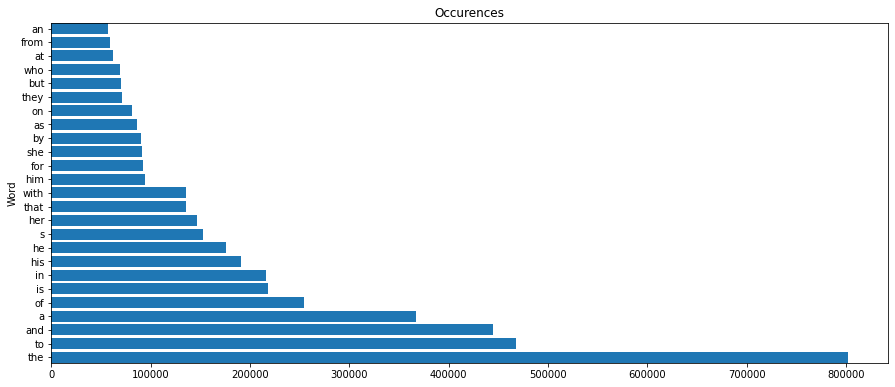

In [ ]:
def wordcount_visualizer(series, n = 30):
  all_words = ' '.join([text for text in series])
  all_words = pd.Series(all_words.split())
  word_count = all_words.value_counts()

  # visualize how many times our words occur
  fig, ax = plt.subplots(figsize = (15,n/4))
  plt.margins(y=0)
  ax.barh(word_count[0:n].index, word_count[0:n].values)
  ax.set_ylabel("Word")
  ax.set_title("Occurences")

# print 100 most frequent words
wordcount_visualizer(movies['synopsis'], 25)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


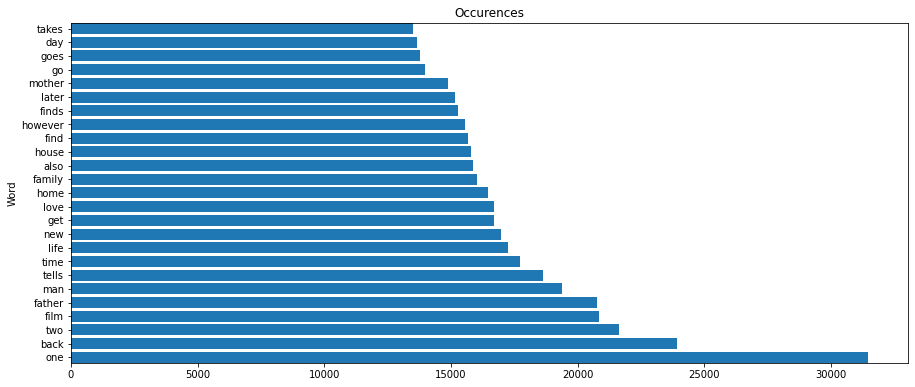

In [ ]:
# need to remove stopwords from our analysis because they contribute nothing to the genre classification and dominate our word count (features)

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['synopsis'] = movies['synopsis'].apply(lambda x: remove_stopwords(x))

wordcount_visualizer(movies['synopsis'], 25)

feature engineering / data splitting

In [ ]:
# multilabel binarizer transforms our labels into a binary 1 hot encoding representing if a label is present or not.
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies['genre'])

# transform target variable
y = multilabel_binarizer.transform(movies['genre'])
# print(y)

# tfidf vectorizer is a special type of vectorizer used for NLP applications,
# it measures the term frequency against the frequency the term appears in all of the dataser to give weight to which words
# have meaning in a particular document and less weight to words that appear frequently in the whole dataset such as: the, and, is etc.
tfidf_vectorizer = TfidfVectorizer( max_features=10000)
count_vec = CountVectorizer(max_features=10000)
# split dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(movies['synopsis'], y, test_size=0.2, random_state=42)

# create TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_C = count_vec.fit_transform(X_train)
X_test_C = count_vec.transform(X_test)


# 0 mean unit std features for rf
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

build the models and gridsearchCV

Logistic Regression

In [ ]:
n_folds = 5

# configure the cross-validation procedure
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# svc_param_grid = {'estimator__C': 10.0**np.arange(-2, 3)}
lr_param_grid = {'estimator__C': 10.0**np.arange(-2, 3)}
# rf_param_grid = {'n_estimators': [10, 100, 500, 1000]}


# clf_svc = OneVsRestClassifier(LinearSVC(random_state = 42))
clf_lr = OneVsRestClassifier(LogisticRegression(solver='sag', random_state = 42))


clf_rf = RandomForestClassifier(random_state = 42, criterion='entropy')
clf_mnb=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
search_lr = GridSearchCV(clf_lr, lr_param_grid, scoring='f1_micro', n_jobs=-1, cv=cv)


# search_svc = GridSearchCV(clf_svc, svc_param_grid, scoring='f1_micro', n_jobs=-1, cv=cv)
# search_rf = GridSearchCV(clf_rf, rf_param_grid, scoring='f1_micro', n_jobs=-1, cv=cv)




In [ ]:

# start = timer()

# result_svc = search_svc.fit(X_train_scaled, y_train)

# end = timer()
# print(end - start) # Time in seconds

In [ ]:

start = timer()

result_lr = search_lr.fit(X_train_tfidf, y_train)

end = timer()
print(end - start) # Time in seconds

807.6044397900041


In [ ]:
# result_rf = search_rf.fit(X_train_scaled, y_train)


start = timer()
# ...
clf_rf = RandomForestClassifier(n_estimators=100, random_state = 42, criterion='entropy')
clf_rf.fit(X_train_scaled, y_train)

end = timer()
print(end - start) # Time in seconds

383.37987589099794


In [ ]:
start = timer()

clf_mnb.fit(X_train_C, y_train)

end = timer()
print(end - start) # Time in seconds

0.5392183200019645


In [ ]:

# best_model_svc = result_svc.best_estimator_
best_model_lr = result_lr.best_estimator_
# best_model_rf = result_rf.best_estimator_


print('\nOptimal model: ')
print(f'lr: {best_model_lr}')

lr_y_pred = best_model_lr.predict(X_test_tfidf)
rf_y_pred = clf_rf.predict(X_test_scaled)
mnb_y_pred = clf_mnb.predict(X_test_tfidf)


print('F1 scores based on micro average: ')
print('logistic regression: ',f1_score(y_test, lr_y_pred, average='micro'))
print('random forest:', f1_score(y_test, rf_y_pred, average='micro'))
print('multnomial Naive Bayes: ',f1_score(y_test, mnb_y_pred, average='micro') )




Optimal model: 
lr: OneVsRestClassifier(estimator=LogisticRegression(C=10.0, random_state=42,
                                                 solver='sag'))
F1 scores based on micro average: 
logistic regression:  0.5183191570394821
random forest: 0.23787167449139282
multnomial Naive Bayes:  0.4433059109406564


In [ ]:
true_labels = pd.Series(multilabel_binarizer.inverse_transform(y_test))
lr_labels = pd.Series(multilabel_binarizer.inverse_transform(lr_y_pred))
rf_labels = pd.Series(multilabel_binarizer.inverse_transform(rf_y_pred))
mnb_labels = pd.Series(multilabel_binarizer.inverse_transform(mnb_y_pred))

frame = { 'Actual': true_labels, 'Logistic Regression': lr_labels, 'Random forest': rf_labels, 'Multinomial Naive Bayes' : mnb_labels }
#Creating DataFrame by passing Dictionary
df = pd.DataFrame(frame)
#Printing elements of Dataframe
df[8125:8150]

,Actual,Logistic Regression,Random forest,Multinomial Naive Bayes
8125,"(action,)",(),(),"(drama,)"
8126,"(crime, drama, fiction, historical)","(drama, fiction, thriller)","(drama,)","(drama, fiction)"
8127,"(drama, musical, romance)","(drama,)","(drama,)","(drama, romance)"
8128,"(comedy, drama, indie)","(drama,)","(drama,)","(drama,)"
8129,"(drama,)","(drama,)","(drama,)","(drama,)"
8130,"(drama,)","(action, drama)","(drama,)","(drama,)"
8131,"(drama,)","(drama,)",(),()
8132,"(action, adventure, fiction, sci-fi)","(action, adventure, drama)","(drama,)","(action, adventure, fiction, sci-fi)"
8133,"(short,)","(musical, romance)","(drama,)",()
8134,"(cult, fiction, horror, sci-fi)","(fiction, horror, sci-fi)",(),"(fiction, sci-fi)"


In [ ]:
# multilabel_binarizer.inverse_transform(y_train)

In [ ]:
# make predictions for validation set
# y_pred = clf.predict(X_test_tfidf)

# print(y_pred)
# multilabel_binarizer.inverse_transform(y_pred)

In [ ]:
# evaluate performance
# f1_score(y_test, y_pred, average='micro')

In [ ]:
# predict probabilities
# y_pred_prob = clf.predict_proba(X_test_tfidf)

In [ ]:
# t = 0.25 # threshold value
# y_pred_new = (y_pred_prob >= t).astype(int)

In [ ]:
# evaluate performance
# f1_score(y_test, y_pred_new, average="micro")